# Review for epsilon-greedy algorithm

### 1. multi-armed problem
- (1) arms: multiple options
- (2) rewards: money with probabilities
- (3) goal: maximize the rewards, minimize the regrets
- (4) gambling: no idea on the arms ahead; figure out the rewards of arms by experimenting; take risks
- (5) strategy: explore-exploit; make use of accumulated knowledge to get some money; take some chances to explore more new ideas which might give you higher returns. 

### 2. epsilon-greedy algorithm

#### 2.1 concepts
- (1) greedy: take the best action at each step; myopic view;lose some potential rewards in new chances; not good for your long-term development. 
- (2) epsilon: assign a probability to allow taking new chances

#### 2.2. technical definitions (define the class)
- (1) counts: (keep track of previous choices)
- (2) values/rewards: keep track of previous rewards
- (3) update knowledge (select arm, update counts and values)
- (4) adjust your decisions/actions (choose the best arm based on this updated knowledge)
- (5) define arms (Bernoulli arms) 


#### 2.3 simulation and test, performance analysis

- (1) run multiple simulations to average noises
- (2) run multiple rounds/plays (horizon) to see the over-time performance
- (3) check the probability of choosing the best arm at each step
- (4) check the average rewards at each step
- (5) check the cumulative rewards at each step

### 3. Definition for Arms with Gaussian Distributed Rewards


In [1]:
## import necessary packages
import random
import math
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [32]:
## define the class of arms
class GaussianArm():
    def __init__(self, mu):
        self.mu = mu
    
    def draw(self):
        return np.random.normal(self.mu, 1)


In [33]:
class EpsilonGreedy():
    
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        if random.random()>self.epsilon: #exploit
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return
        

In [34]:
## define test_algorithm
def test_algorithm (algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize (len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t -1 
            sim_nums[index] = sim
            times[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]
            

In [35]:
## simulation and test
import pandas as pd
import os
random.seed(4014)
suffix = "_eg_gaussian_s1000_s500_std001"
output = ("simulate"+suffix+".csv")

# initialization, arms
n_arms = 10
mus = np.random.normal(0, 0.01, n_arms) # [1,3, 4,...]
print ("The arm with the highest mean value is {}".format(np.argmax(mus)))
arms = list(map(lambda mu: GaussianArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 1000
N_STEPS = 500
overall_count = 0

# loop to simulate

for epsilon in [0.1, 0.8]:
    eg_algo = EpsilonGreedy(epsilon, [], [])
    eg_algo.initialize(n_arms)
    results = pd.DataFrame(test_algorithm(eg_algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
    results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
    results['epsilon'] = epsilon
    if overall_count == 0:
        results.to_csv(output, index = False)
    else:
        results.to_csv(output, index = False, mode='a',header=None)
    overall_count=overall_count + 1


The arm with the highest mean value is 5


(1000000, 7)
   n_sim  n_step  chosen_arm   rewards  cumulative_rewards  epsilon  \
0    1.0     1.0         0.0 -0.069062           -0.069062      0.1   
1    1.0     2.0         1.0  2.224361            2.155299      0.1   

   if_best_arm  
0            0  
1            0  
['n_sim', 'n_step', 'chosen_arm', 'rewards', 'cumulative_rewards', 'epsilon', 'if_best_arm']


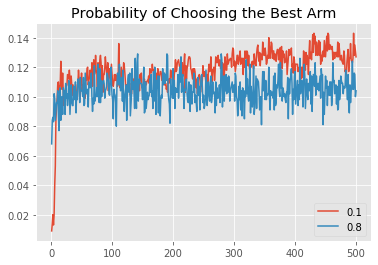

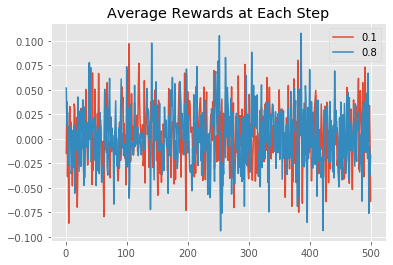

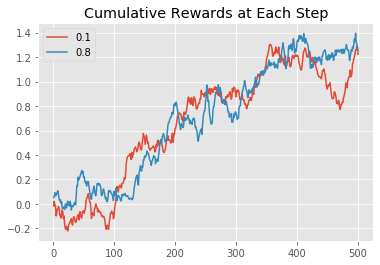

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

suffix = "_eg_gaussian_s1000_s500_std001"
output = ("simulate"+suffix+".csv")
all_results = pd.read_csv(output)
all_results ['if_best_arm'] = np.where(all_results['chosen_arm']==np.argmax(mus), 1,0)
# all_results = all_results[all_results['n_step']<101]
print(all_results.shape)
print(all_results.iloc[:2,])
print(all_results.columns.values.tolist())

results_plot = all_results.groupby(['epsilon','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure()
ax = fig.add_subplot(111)
for epsilon in results_plot['epsilon'].unique():
    ax.plot(results_plot[results_plot['epsilon']==epsilon]['n_step'],results_plot[results_plot['epsilon']==epsilon]['if_best_arm'], label=str(epsilon))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure()
ax = fig.add_subplot(111)
for epsilon in results_plot['epsilon'].unique():
    ax.plot(results_plot[results_plot['epsilon']==epsilon]['n_step'],results_plot[results_plot['epsilon']==epsilon]['rewards'], label=str(epsilon))
plt.legend()
plt.title('Average Rewards at Each Step')
plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure()
ax = fig.add_subplot(111)
for epsilon in results_plot['epsilon'].unique(): 
    ax.plot(results_plot[results_plot['epsilon']==epsilon]['n_step'],results_plot[results_plot['epsilon']==epsilon]['cumulative_rewards'], label=str(epsilon))
plt.legend()
plt.title('Cumulative Rewards at Each Step')
plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)


### 3.2 Question:

How will the diversity of arms influence the algorithm's performance?

### 4. Epsilon-Decay Algorithm

- (1) The standard epsilon-greedy algorithm uses the fixed epsilon value over time. But the algorithm actually can figure out which options are really bad after some time. There is really no need to explore on these options any more. 
- (2) Design an algorithm that can adapt the epsilon value based on the time. Explore more in the earlier periods while exploit more in the later periods. 
- (3) Formula: epsilon = 1/(sum(self.counts)/len(self.counts)+1)  or epsilon = 1/(num_plays/(num_arms)+1) 
  - epsilon = 1/(1+beta*time_counts) (e.g., log transformation on the time counts)


In [37]:
class EpsilonDecay():
    
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        if random.random()>1/(sum(self.counts)/len(self.counts)+1): #exploit
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return
        

In [38]:
## simulation and test
import pandas as pd
import os
random.seed(4014)
suffix = "_egdecay_gaussian_s1000_s500_std01"
output = ("simulate"+suffix+".csv")

# initialization, arms
n_arms = 10
mus = np.random.normal(0, 0.1, n_arms) # [1,3, 4,...]
print ("The arm with the highest mean value is {}".format(np.argmax(mus)))
arms = list(map(lambda mu: GaussianArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 1000
N_STEPS = 500
overall_count = 0

# loop to simulate
eg_algo = EpsilonDecay([], [])
eg_algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(eg_algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['epsilon'] = "decay"
if overall_count == 0:
    results.to_csv(output, index = False)
else:
    results.to_csv(output, index = False, mode='a',header=None)
overall_count=overall_count + 1
## num of arms, business environment, type of arm

The arm with the highest mean value is 1
